In [2]:
import numpy as np
import pandas as pd  #读取csv文件的库
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
#让输出图形直接在Notebook中显示
% matplotlib inline

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


Text(0, 0.5, 'Y')

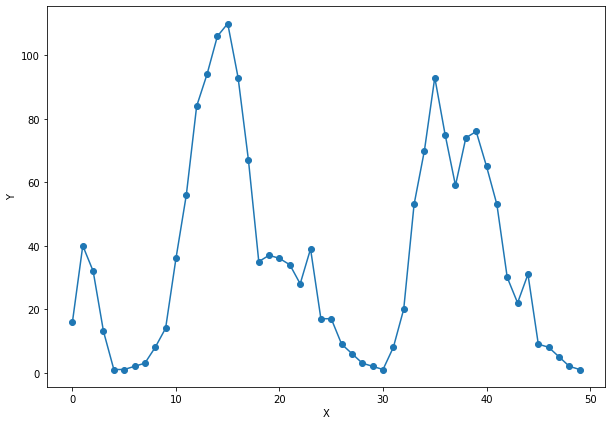

In [3]:
data_path = 'hour.csv'  #读取数据到内存，rides为一个dataframe对象
rides = pd.read_csv(data_path)
print(rides.head())  #输出部分数据
counts = rides['cnt'][:50]  #截取数据
x = np.arange(len(counts))  #获取变量x
y = np.array(counts)  #单车数量为y
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
plt.plot(x, y, 'o-')  #绘制原始数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注

In [4]:
#输入变量，1,2,3,...这样的一维数组
x = torch.FloatTensor(np.arange(len(counts), dtype=float))
#输出变量，它是从数据counts中读取的每一时刻的单车数，共50个数据点的一维数组，作为标准答案
y = torch.FloatTensor(np.array(counts, dtype=float))

In [5]:
sz = 10  #设置隐含层神经元的数量
#初始化输入层到隐含层的权重矩阵，它的尺寸是(1,10)
weights = torch.randn((1, sz), requires_grad=True)
#初始化隐含层节点的偏置向量，它是尺寸为10的一维向量
biases = torch.randn((sz), requires_grad=True)
#初始化从隐含层到输出层的权重矩阵，它的尺寸是(10,1)
weights2 = torch.randn((sz, 1), requires_grad=True)

In [6]:
learning_rate = 0.001  #设置学习率
losses = []  #该数组记录每一次迭代的损失函数值，以方便后续绘图
x = x.view(50, -1)
y = y.view(50, -1)
for i in range(100000):
    #从输入层到隐含层的计算
    hidden = x * weights + biases
    #此时，hidden变量的尺寸是：(50,10)，即50个数据点，10个隐含层神经元

    #将sigmoid函数作用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    #隐含层输出到输出层，计算得到最终预测
    predictions = hidden.mm(weights2)
    #此时，predictions的尺寸为：(50,1)，即50个数据点的预测数值
    #通过与数据中的标准答案y做比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2)
    #此时，loss为一个标量，即一个数
    losses.append(loss.data.numpy())

    if i % 10000 == 0:  #每隔10000个周期打印一下损失函数数值
        print('loss:', loss)

    #*****************************************
    #接下来开始梯度下降算法，将误差反向传播
    loss.backward()  #对损失函数进行梯度反传

    #利用上一步计算中得到的weights，biases等梯度信息更新weights或biases的数值
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)

    #清空所有变量的梯度值
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(2353.3030, grad_fn=<MeanBackward0>)
loss: tensor(845.6080, grad_fn=<MeanBackward0>)
loss: tensor(566.7391, grad_fn=<MeanBackward0>)
loss: tensor(514.8759, grad_fn=<MeanBackward0>)
loss: tensor(479.1893, grad_fn=<MeanBackward0>)
loss: tensor(470.5212, grad_fn=<MeanBackward0>)
loss: tensor(467.8291, grad_fn=<MeanBackward0>)
loss: tensor(466.4767, grad_fn=<MeanBackward0>)
loss: tensor(465.4838, grad_fn=<MeanBackward0>)
loss: tensor(464.7708, grad_fn=<MeanBackward0>)


Text(0, 0.5, 'Loss')

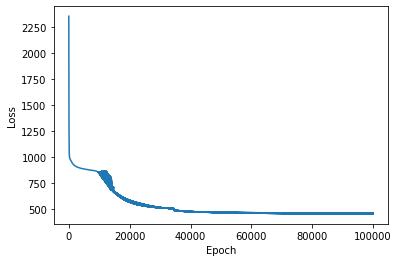

In [7]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

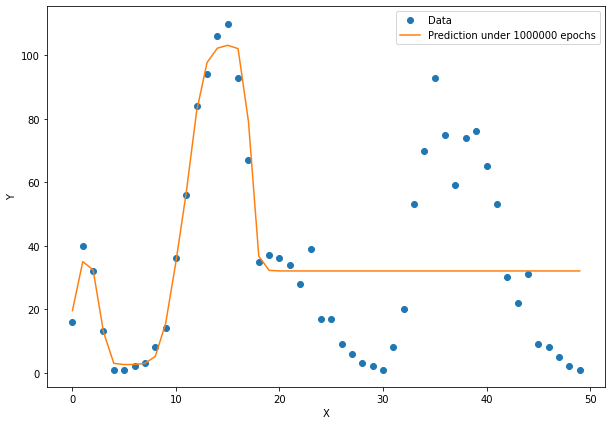

In [8]:
x_data = x.data.numpy()  #获得x包裹的数据
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o')  #绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注
plt.legend([xplot, yplot], ['Data', 'Prediction under 1000000 epochs'])  #绘制图例
plt.show()

In [9]:
"""
x的取值范围是1~50，而所有权重和偏置的初始值都是被设定在(-1, 1)的正态分布随机数，那么输入层到隐含层节点的数值范围就成了-50~50，要想将sigmoid函数的多个峰值调节到我们期望的位置需要耗费很多计算时间。事实上，如果让训练时间更长些，我们可以将曲线后面的部分拟合得很好。

这个问题的解决方法是将输入数据的范围做归一化处理，也就是让x的输入数值范围为0~1。因为数据中x的范围是1~50，所以，我们只需要将每一个数值都除以50就可以了
"""

'\nx的取值范围是1~50，而所有权重和偏置的初始值都是被设定在(-1, 1)的正态分布随机数，那么输入层到隐含层节点的数值范围就成了-50~50，要想将sigmoid函数的多个峰值调节到我们期望的位置需要耗费很多计算时间。事实上，如果让训练时间更长些，我们可以将曲线后面的部分拟合得很好。\n\n这个问题的解决方法是将输入数据的范围做归一化处理，也就是让x的输入数值范围为0~1。因为数据中x的范围是1~50，所以，我们只需要将每一个数值都除以50就可以了\n'

In [10]:
x = torch.FloatTensor(np.arange(len(counts), dtype=float) / len(counts))

In [11]:
learning_rate = 0.001  #设置学习率
losses = []  #该数组记录每一次迭代的损失函数值，以方便后续绘图
x = x.view(50, -1)
y = y.view(50, -1)
for i in range(100000):
    #从输入层到隐含层的计算
    hidden = x * weights + biases
    #此时，hidden变量的尺寸是：(50,10)，即50个数据点，10个隐含层神经元

    #将sigmoid函数作用在隐含层的每一个神经元上
    hidden = torch.sigmoid(hidden)
    #隐含层输出到输出层，计算得到最终预测
    predictions = hidden.mm(weights2)
    #此时，predictions的尺寸为：(50,1)，即50个数据点的预测数值
    #通过与数据中的标准答案y做比较，计算均方误差
    loss = torch.mean((predictions - y) ** 2)
    #此时，loss为一个标量，即一个数
    losses.append(loss.data.numpy())

    if i % 10000 == 0:  #每隔10000个周期打印一下损失函数数值
        print('loss:', loss)

    #*****************************************
    #接下来开始梯度下降算法，将误差反向传播
    loss.backward()  #对损失函数进行梯度反传

    #利用上一步计算中得到的weights，biases等梯度信息更新weights或biases的数值
    weights.data.add_(- learning_rate * weights.grad.data)
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)

    #清空所有变量的梯度值
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()

loss: tensor(1124.6902, grad_fn=<MeanBackward0>)
loss: tensor(774.1407, grad_fn=<MeanBackward0>)
loss: tensor(515.8614, grad_fn=<MeanBackward0>)
loss: tensor(446.1816, grad_fn=<MeanBackward0>)
loss: tensor(421.4604, grad_fn=<MeanBackward0>)
loss: tensor(411.4986, grad_fn=<MeanBackward0>)
loss: tensor(406.9312, grad_fn=<MeanBackward0>)
loss: tensor(404.5236, grad_fn=<MeanBackward0>)
loss: tensor(403.0709, grad_fn=<MeanBackward0>)
loss: tensor(402.0908, grad_fn=<MeanBackward0>)


Text(0, 0.5, 'Loss')

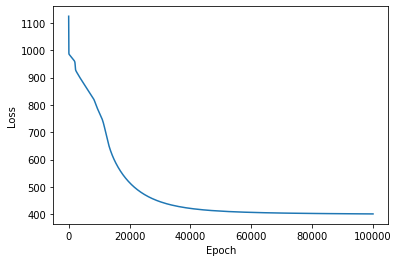

In [12]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

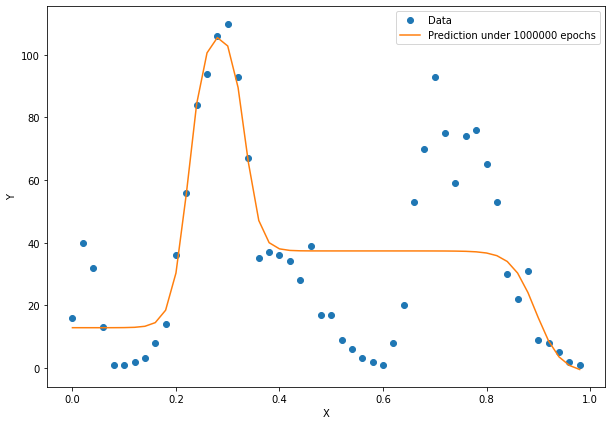

In [13]:
x_data = x.data.numpy()  #获得x包裹的数据
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o')  #绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注
plt.legend([xplot, yplot], ['Data', 'Prediction under 1000000 epochs'])  #绘制图例
plt.show()

tensor(8662.5449, grad_fn=<MeanBackward0>)


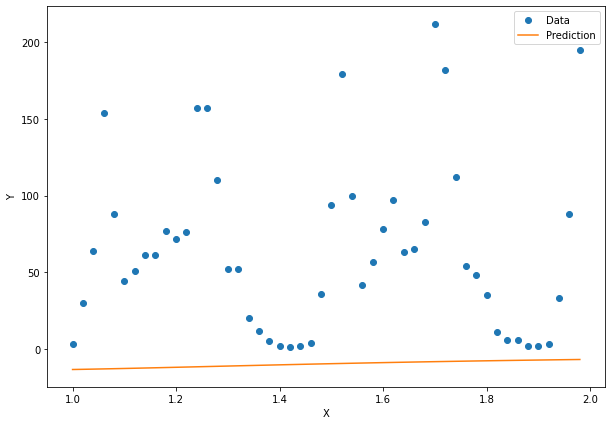

In [14]:
counts_predict = rides['cnt'][50:100]  #读取待预测的后面50个数据点
x = torch.FloatTensor((np.arange(len(counts_predict), dtype=float) + len(counts)) / len(counts))
#读取后面50个点的y数值，不需要做归一化
y = torch.FloatTensor(np.array(counts_predict, dtype=float))

#用x预测y
hidden = x.expand(sz, len(x)).t() * weights.expand(len(x), sz)  #从输入层到隐含层的计算
hidden = torch.sigmoid(hidden)  #将sigmoid函数作用在隐含层的每一个神经元上
predictions = hidden.mm(weights2)  #从隐含层输出到输出层，计算得到最终预测
loss = torch.mean((predictions - y) ** 2)  #计算预测数据上的损失函数
print(loss)

#将预测曲线绘制出来
x_data = x.data.numpy()  #获得x包裹的数据
plt.figure(figsize=(10, 7))  #设定绘图窗口大小
xplot, = plt.plot(x_data, y.data.numpy(), 'o')  #绘制原始数据
yplot, = plt.plot(x_data, predictions.data.numpy())  #绘制拟合数据
plt.xlabel('X')  #更改坐标轴标注
plt.ylabel('Y')  #更改坐标轴标注
plt.legend([xplot, yplot], ['Data', 'Prediction'])  #绘制图例
plt.show()

In [15]:
#单车预测器2.0

In [16]:
#类型数据的处理
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']  #所有类型编码变量的名称
for each in dummy_fields:
    #取出所有类型变量，并将它们转变为独热编码
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    #将新的独热编码变量与原有的所有变量合并到一起
    rides = pd.concat([rides, dummies], axis=1)

#将原来的类型变量从数据表中删除
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday',
                  'hr']  #要删除的类型变量的名称
data = rides.drop(fields_to_drop, axis=1)  #将它们从数据库的变量中删除
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0000,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0000,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0000,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0000,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0000,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0.26,0.60,0.1642,11,108,119,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,0.26,0.60,0.1642,8,81,89,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,0.26,0.60,0.1642,7,83,90,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,0.26,0.56,0.1343,13,48,61,1,0,...,0,1,0,0,1,0,0,0,0,0


In [17]:
quant_features = ['cnt', 'temp', 'hum', 'windspeed']  #数值类型变量的名称
scaled_features = {}  #将每一个变量的均值和方差都存储到scaled_features变量中
for each in quant_features:
    #计算这些变量的均值和方差
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    #对每一个变量进行标准化
    data.loc[:, each] = (data[each] - mean) / std

In [18]:
data

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,3,13,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,8,32,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,5,27,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,3,10,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,0,1,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,-1.230743,-0.141133,-0.211685,11,108,-0.388467,1,0,...,0,0,0,0,1,0,0,0,0,0
17375,1,0,-1.230743,-0.141133,-0.211685,8,81,-0.553859,1,0,...,0,0,0,0,1,0,0,0,0,0
17376,1,0,-1.230743,-0.141133,-0.211685,7,83,-0.548346,1,0,...,1,0,0,0,1,0,0,0,0,0
17377,1,0,-1.230743,-0.348463,-0.456086,13,48,-0.708224,1,0,...,0,1,0,0,1,0,0,0,0,0


In [19]:
test_data = data[-21 * 24:]  #选出测试集
train_data = data[:-21 * 24]  #选出训练集

#目标列包含的字段
target_fields = ['cnt', 'casual', 'registered']

#训练集划分成特征变量列和目标特征列
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

#测试集划分成特征变量列和目标特征列
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

#将数据类型转换为NumPy数组
X = features.values  #将数据从pandas dataframe转换为NumPy
Y = targets['cnt'].values
Y = Y.astype(float)

Y = np.reshape(Y, [len(Y), 1])
losses = []

In [20]:
test_data = data[-21 * 24:]  #选出训练集
train_data = data[:-21 * 24]  #选出测试集

#目标列包含的字段
target_fields = ['cnt', 'casual', 'registered']

#训练集划分成特征变量列和目标特征列
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

#测试集划分成特征变量列和目标特征列
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

#将数据类型转换为NumPy数组
X = features.values  #将数据从pandas dataframe转换为NumPy
Y = targets['cnt'].values
Y = Y.astype(float)

In [21]:
Y

array([-0.95631172, -0.82399838, -0.86810283, ...,  1.30955431,
        0.60939619,  0.30617811])

In [22]:
np.reshape(Y, [len(Y), 1])

array([[-0.95631172],
       [-0.82399838],
       [-0.86810283],
       ...,
       [ 1.30955431],
       [ 0.60939619],
       [ 0.30617811]])

In [23]:
Y = np.reshape(Y, [len(Y), 1])
losses = []
Y

array([[-0.95631172],
       [-0.82399838],
       [-0.86810283],
       ...,
       [ 1.30955431],
       [ 0.60939619],
       [ 0.30617811]])

In [24]:
#定义神经网络架构，features.shape[1]个输入层单元，10个隐含层，1个输出层
input_size = features.shape[1]
hidden_size = 10
output_size = 1
batch_size = 128
neu = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)

In [25]:
cost = torch.nn.MSELoss()
optimizer = torch.optim.SGD(neu.parameters(), lr=0.01)

0 0.8962007
100 0.26767695
200 0.23584996
300 0.17619994
400 0.119527526
500 0.09097216
600 0.08122108
700 0.076701865
800 0.07319702
900 0.06998061


Text(0, 0.5, 'MSE')

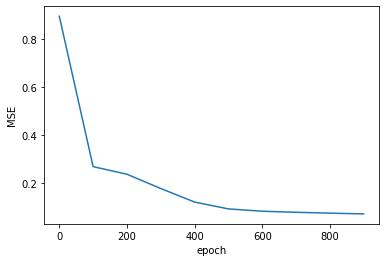

In [26]:
#神经网络训练循环
losses = []
for i in range(1000):
    #每128个样本点被划分为一批，在循环的时候一批一批地读取
    batch_loss = []
    #start和end分别是提取一批数据的起始和终止下标
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.FloatTensor(X[start:end])
        yy = torch.FloatTensor(Y[start:end])
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())

    #每隔100步输出损失值
    if i % 100 == 0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

#打印输出损失值
plt.plot(np.arange(len(losses)) * 100, losses)
plt.xlabel('epoch')
plt.ylabel('MSE')

In [27]:
targets = test_targets['cnt']  #读取测试集的cnt数值
targets  #sierce

16875   -0.349876
16876   -0.581424
16877   -0.873616
16878   -1.000416
16879   -1.039008
           ...   
17374   -0.388467
17375   -0.553859
17376   -0.548346
17377   -0.708224
17378   -0.774381
Name: cnt, Length: 504, dtype: float64

In [28]:
targets = targets.values.reshape([len(targets), 1])  #将数据转换成合适的tensor形式
targets  #numpy narry

array([[-3.49875559e-01],
       [-5.81423913e-01],
       [-8.73615883e-01],
       [-1.00041617e+00],
       [-1.03900756e+00],
       [-1.02798145e+00],
       [-1.00041617e+00],
       [-8.18485323e-01],
       [-3.93980007e-01],
       [ 1.05044068e+00],
       [ 2.94693196e+00],
       [ 7.96840099e-01],
       [-1.95509990e-01],
       [-9.07619248e-02],
       [ 2.01430046e-01],
       [ 3.55795615e-01],
       [ 8.01428126e-02],
       [ 4.44004512e-01],
       [ 9.29153444e-01],
       [ 2.26882606e+00],
       [ 1.96560798e+00],
       [ 1.34263265e+00],
       [ 3.72334783e-01],
       [ 9.66819808e-02],
       [-4.60136680e-01],
       [-6.91685034e-01],
       [-8.57076715e-01],
       [-9.28746444e-01],
       [-9.94903117e-01],
       [-9.89390060e-01],
       [-1.02246840e+00],
       [-8.40537547e-01],
       [-3.38849447e-01],
       [ 9.89797060e-01],
       [ 2.74846194e+00],
       [ 5.26700352e-01],
       [-2.94744999e-01],
       [-9.62749809e-02],
       [ 2.3

In [29]:
targets = targets.astype(float)  #保证数据为实数

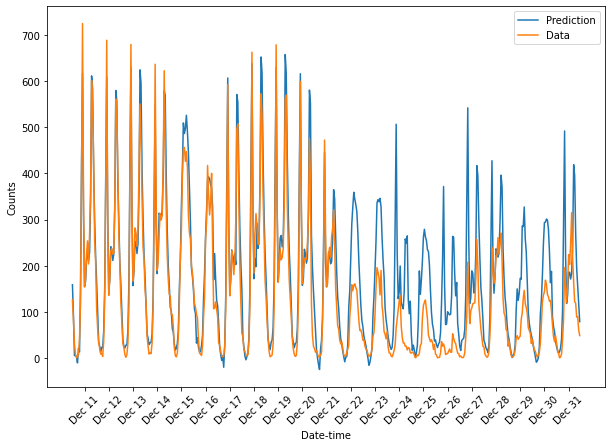

In [30]:
x = torch.FloatTensor(test_features.values)
y = torch.FloatTensor(targets)

#用神经网络进行预测
predict = neu(x)
predict = predict.data.numpy()

fig, ax = plt.subplots(figsize=(10, 7))

mean, std = scaled_features['cnt']
ax.plot(predict * std + mean, label='Prediction')
ax.plot(targets * std + mean, label='Data')
ax.legend()
ax.set_xlabel('Date-time')
ax.set_ylabel('Counts')
dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [31]:
def feature(X, net):
    #定义一个函数，用于提取网络的权重信息，所有的网络参数信息全部存储在neu的named_parameters集合中
    X = torch.from_numpy(X).type(torch.FloatTensor)
    dic = dict(net.named_parameters())  #提取这个集合
    weights = dic['0.weight']  #可以按照“层数.名称”来索引集合中的相应参数值
    biases = dic['0.bias']
    h = torch.sigmoid(X.mm(weights.t()) + biases.expand([len(X), len(biases)]))  #隐含层的计算过程
    return h  #输出层的计算

In [32]:
bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

#将3个布尔型数组求与
bools = [any(tup) for tup in zip(bool1, bool2, bool3)]
#将相应的变量取出来
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets), 1])

In [40]:
dic = dict(neu.named_parameters())  #提取这个集合
print(dic)

{'0.weight': Parameter containing:
tensor([[-7.0316e-02, -5.4488e-02, -2.9185e-01,  1.5154e-01,  1.3085e-01,
          1.3799e-01, -3.8997e-02, -1.0729e-02, -6.3888e-02,  3.8435e-02,
         -8.1636e-02, -5.5729e-03,  1.1523e-03,  5.6804e-02, -1.1619e-01,
         -1.2614e-02, -5.2225e-02, -3.0646e-02, -1.1084e-01,  1.1707e-01,
         -5.9838e-02, -3.6752e-02, -1.1778e-01, -2.7848e-03,  1.4319e-02,
         -6.3485e-02, -1.5999e-02,  3.4538e-02,  2.0610e-02,  1.6630e-01,
          3.4623e-02,  8.5505e-02,  1.4679e-01, -7.1482e-02,  2.2524e-02,
         -1.9156e-02, -2.2637e-01, -2.1411e-01, -1.1823e-01, -1.2205e-01,
         -2.0478e-01, -1.8093e-02,  4.4899e-03,  6.7488e-02,  3.6246e-02,
          1.3494e-02,  7.2480e-02, -1.3395e-02,  2.0426e-02, -4.1330e-02,
          4.4508e-02,  5.4070e-02, -1.0215e-01, -4.5503e-02, -4.6621e-02,
          1.1799e-01],
        [-3.9612e-02, -2.6035e-02, -1.2456e-01,  1.4930e-01,  3.2453e-02,
         -2.0281e-02,  1.2540e-01, -9.5265e-02,  3.511

In [33]:
#将数据输入到神经网络中，读取隐含层神经元的激活数值，存入results中
results = feature(subset.values, neu).data.numpy()
#这些数据对应的预测值（输出层）
predict = neu(torch.FloatTensor(subset.values)).data.numpy()
#将预测值还原为原始数据的数值范围
mean, std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean

In [35]:
print(results)
print(predict)

[[0.68371785 0.5784598  0.10719537 0.0716508  0.0275691  0.00288065
  0.01463725 0.26822084 0.9347078  0.12315477]
 [0.66256726 0.51971215 0.13975362 0.06186372 0.03030213 0.00256629
  0.01416467 0.26259392 0.9506748  0.15474276]
 [0.6910603  0.5237758  0.12128421 0.04988066 0.0296128  0.00293075
  0.01480371 0.26571193 0.94699556 0.12381003]
 [0.677604   0.52237904 0.14230648 0.04415558 0.03786231 0.00298473
  0.01215709 0.27899522 0.96038646 0.12986141]
 [0.64954144 0.4977379  0.31853905 0.04629043 0.03617886 0.00323313
  0.01190518 0.28799316 0.9625414  0.1654234 ]
 [0.6736668  0.5456206  0.17644559 0.04483066 0.0393803  0.00390481
  0.01058377 0.25275496 0.96296316 0.1097541 ]
 [0.6779312  0.5190308  0.19599812 0.05286196 0.03445709 0.00642663
  0.00821455 0.31753257 0.95648587 0.12357455]
 [0.691163   0.46103066 0.19701032 0.08791497 0.03222315 0.01719184
  0.00376896 0.32076365 0.9557358  0.09660763]
 [0.68885803 0.52562195 0.10182374 0.16383332 0.03208887 0.03340385
  0.00213181

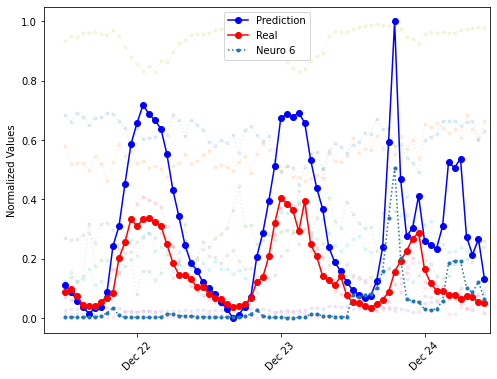

In [77]:
#将所有的神经元激活水平画在同一张图上
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(results[:, :], '.:', alpha=0.1)
ax.plot((predict - min(predict)) / (max(predict) - min(predict)), 'bo-', label='Prediction')
ax.plot((subtargets - min(predict)) / (max(predict) - min(predict)), 'ro-', label='Real')
ax.plot(results[:, 5], '.:', alpha=1, label='Neuro 6')

ax.set_xlim(right=len(predict))
ax.legend()
plt.ylabel('Normalized Values')

dates = pd.to_datetime(rides.loc[subset.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)


Text(0, 0.5, 'Weight')

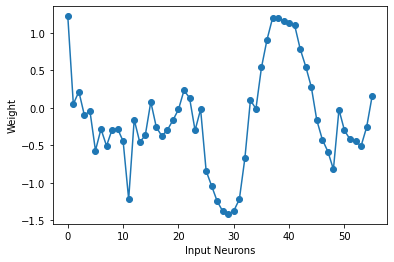

In [76]:
#找到与峰值对应的神经元，将其到输入层的权重输出
dic = dict(neu.named_parameters())
weights = dic['0.weight']
plt.plot(weights.data.numpy()[3, :], 'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')

Text(0, 0.5, 'Weight')

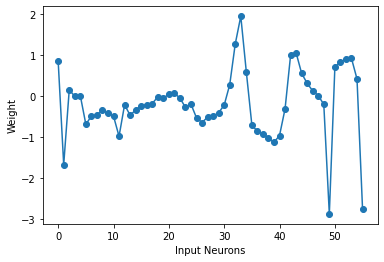

In [65]:
#找到与峰值对应的神经元，将其到输入层的权重输出
dic = dict(neu.named_parameters())
weights = dic['0.weight']
plt.plot(weights.data.numpy()[5, :], 'o-')
plt.xlabel('Input Neurons')
plt.ylabel('Weight')